In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import PAIRWISE_KERNEL_FUNCTIONS
from sklearn.metrics.pairwise import euclidean_distances, rbf_kernel, pairwise_kernels

def standardize(x):
	return (x - x.mean(dim=0)) / x.std(dim=0)

# def get_rbf_kernel(x, gamma=1):
#     pairwise_dists = torch.cdist(x, x, p=2) ** 2
#     # pairwise_dists = torch.from_numpy(euclidean_distances(x, x)) ** 2
#     return (-gamma * pairwise_dists).exp()

def compute_kernel(x, y=None, kernel="linear", **params):
    if kernel not in PAIRWISE_KERNEL_FUNCTIONS:
        raise ValueError(f"invalid kernel: {kernel}")

    return pairwise_kernels(x, y, metric=kernel, filter_params=True, **params)
                   
def get_hsic(x, y, kernel, center=False, normalize=False, **params):
    K_x = compute_kernel(x, kernel=kernel, **params)
    K_y = compute_kernel(y, kernel=kernel, **params)
   
    if center == True:
        K_x = KernelCenterer().fit_transform(K_x)
        K_y = KernelCenterer().fit_transform(K_y)
   
    hsic = np.sum(K_x * K_y)

    if normalize:
        K_x_norm = np.linalg.norm(K_x)
        K_y_norm = np.linalg.norm(K_y)
        hsic /= (K_x_norm * K_y_norm)

    return hsic

In [2]:
%load_ext autoreload
%autoreload 2

In [90]:
def standardize(x):
	return (x - x.mean(axis=0)) / x.std(axis=0)

In [108]:
import numpy as np 
from collections import defaultdict
# from hsic import HSIC
from pysim.pysim.kernel.hsic import HSIC

batch_size = 128
x_size = 64

sd = 1
repeats = 100
gammas = 10**np.linspace(-7,0,8)
deps = np.linspace(0, 1, 21)
means, sds = defaultdict(list), defaultdict(list)
# means, sds = [], []
# reg_strengths = defaultdict(list)

for gamma in gammas:
    for dep in deps:
        values = []
        # regs = []
        for _ in range(repeats):
        
            X = sd * np.random.randn(batch_size, x_size)
            eps = sd * np.random.randn(batch_size, x_size)
            Y = dep * X + (1 - dep) * eps
    
            # coef = np.corrcoef(X.flatten(), Y.flatten())[0,1]

            # only for HSIC calc
            # X = standardize(X)
            # Y = standardize(Y)
            
            hsic_clf = HSIC(center=True, kernel="rbf", gamma_X=gamma, gamma_Y=gamma) 
            # hsic_clf = HSIC(center=True, kernel="rbf") ## gives a nice graph..
            hsic_clf.fit(X, Y)
    
            # K_x = hsic_clf.K_x
            # K_y = hsic_clf.K_y
                    
            hsic_score = hsic_clf.hsic_value
            # reg_strength = hsic_score / batch_size
            cka_score = hsic_clf.score(X, normalize=True)
    
            # values.append(hsic_score)
            values.append(cka_score)
            # regs.append(reg_strength)
        
        means[gamma].append(np.mean(values))
        sds[gamma].append(np.std(values))

        # reg_strengths[gamma].append(np.mean(regs))
        
        # print(round(dep,1), round(hsic_score, 4), round(cka_score, 4), round(coef, 3))

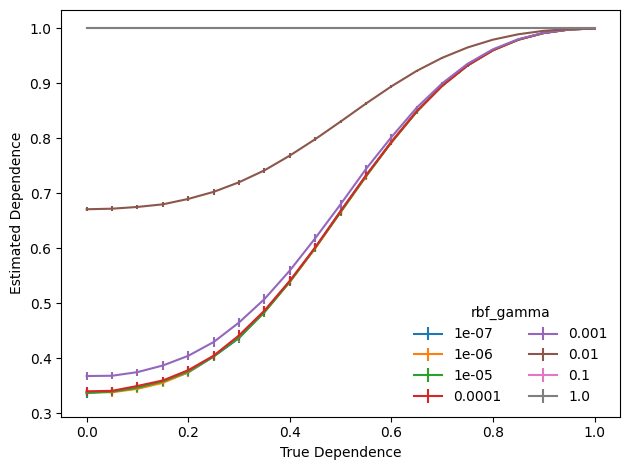

In [113]:
import matplotlib.pyplot as plt 

for k in gammas:
    plt.errorbar(deps, means[k], yerr=sds[k], label=k)

# for k in gammas:
#     if k >= 0.1: continue
#     means_ = means[k] / means[k][0]
#     sds_ = sds[k] / sds[k][0]
#     plt.errorbar(deps, means_, yerr=sds_, label=k)

plt.xlabel("True Dependence")
plt.ylabel("Estimated Dependence")
plt.tight_layout()
plt.legend(title="rbf_gamma", frameon=False, ncols=2)

In [65]:
# estimating gamma..
from scipy.spatial.distance import pdist, squareform

sigma = np.median(pdist(X))
gamma = 1 / (2 * sigma ** 2)
print(gamma)

n_samples, _ = X.shape
percent = 0.15

kth_sample = int(percent * n_samples)
sigma = np.median(np.sort(squareform(pdist(X)))[:, kth_sample])
gamma = 1 / (2 * sigma ** 2)
gamma

0.0039717702219363065


0.004736003247742319

## TODO: replicate code in torch..!

In [21]:
batch_size = 1024
x_size = 128

sd = 1
deps = np.linspace(0,1,11)
for dep in deps:
    x = sd * torch.randn(batch_size, x_size)
    eps = sd * torch.randn(batch_size, x_size)
    y = dep * x + (1 - dep) * eps
    corr = torch.corrcoef(torch.concat([x, y]).reshape(2,-1))[0,1]
    v = get_hsic(x, y, kernel="rbf", gamma=1)
    print(round(dep,1), v.item(), round(corr.item(),3))

rbf {'gamma': 1}
rbf {'gamma': 1}
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
0.0 1024.0 -0.001
rbf {'gamma': 1}
rbf {'gamma': 1}
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
0.1 1024.0 0.111
rbf {'gamma': 1}
rbf {'gamma': 1}
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
0.2 1024.0 0.241
rbf {'gamma': 1}
rbf {'gamma': 1}
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
0.3 1024.0 0.391
rbf {'gamma': 1}
rbf {'gamma': 1}
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0.

In [194]:
# torch.cdist vs euclidean_distances
from sklearn.metrics.pairwise import euclidean_distances

sizes = [1, 10, 100, 1000]
for size in sizes:
    X = torch.randn(size, size)
    d1 = torch.from_numpy(euclidean_distances(X, X))
    d2 = torch.cdist(X, X, p=2)
    err = torch.abs(d1 - d2).sum().item()
    err_diag = torch.diagonal(torch.abs(d1 - d2)).sum().item()
    print(size, err, err_diag, err_diag/(err+1e-5))

1 0.0 0.0 0.0
10 9.059906005859375e-06 0.0 0.0
100 0.2410551756620407 0.2384592890739441 0.9891901159885909
1000 13.98359489440918 13.226011276245117 0.9458227242628289


In [37]:
# !rm -rf pysim
# !git clone https://github.com/jejjohnson/pysim.git
# import sys; sys.path.append("pysim")
from pysim.pysim.kernel.hsic import HSIC

In [39]:
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, pairwise_kernels
from sklearn.preprocessing import KernelCenterer
samples, features = 100, 50
X = np.random.randn(samples, features)
A = np.random.rand(features, features)
Y = X @ A

hsic_clf = HSIC(center=True, kernel="rbf", kernel_params={"gamma": 1})
hsic_clf.fit(X, Y)
cka_score = hsic_clf.score(X, normalize=True) # normalize = True
print(f"<K_x,K_y> / ||K_xx|| / ||K_yy||: {cka_score}")

<K_x,K_y> / ||K_xx|| / ||K_yy||: 0.34268151932496677


In [44]:
from collections import defaultdict

# tests
x_size = 64
batch_size = 128
repeats = 100
sd = 1
gammas = 2**np.linspace(-5, 5, 11)
deps = np.linspace(0, 1, 11)
means, sds = defaultdict(list), defaultdict(list)
for gamma in gammas:
    print(gamma)
    for dep in deps:
    	values = []
    	for _ in range(repeats):
            x = sd * torch.randn(batch_size, x_size)
            eps = sd * torch.randn(batch_size, x_size)
            y = dep * x + (1 - dep) * eps
            # hsic = get_hsic(x, y, gamma)
            hsic_clf = HSIC(center=True, kernel="rbf", kernel_params={"gamma": gamma})
            hsic_clf.fit(X, Y)
            cka_score = hsic_clf.score(X, normalize=False)
            values.append(cka_score)
    
    	means[gamma].append(np.mean(values))
    	sds[gamma].append(np.std(values))

0.03125
0.0625
0.125
0.25
0.5
1.0
2.0
4.0
8.0
16.0
32.0


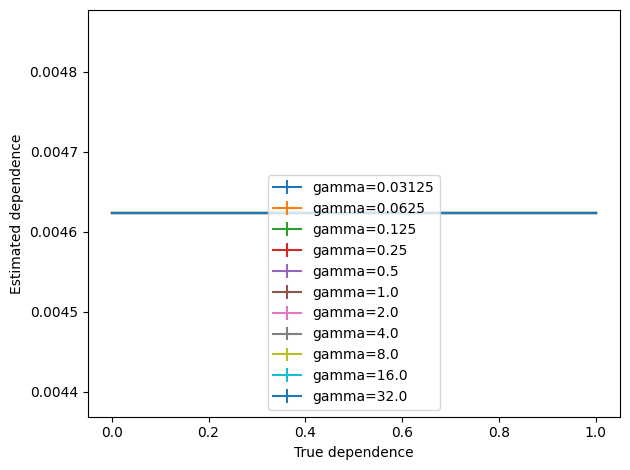

In [45]:
for gamma in means:
    plt.errorbar(deps, means[gamma], yerr=sds[gamma], label=f"gamma={gamma}")
    
plt.xlabel("True dependence")
plt.ylabel("Estimated dependence")
plt.tight_layout()
plt.legend()

In [46]:
means[gamma] # same..?

[0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794,
 0.004622729180374794]

In [190]:
get_hsic(torch.from_numpy(X), 
         torch.from_numpy(Y), gamma=1)

tensor(9.9000e-07, dtype=torch.float64)

In [191]:
def compute_kernel(X, Y=None, kernel="linear", **params):
    print(f"kernel={kernel}, params={params}")
    return pairwise_kernels(X, Y, metric=kernel, filter_params=True, **params)

def get_hsic2(X, Y, kernel, gamma=1, center=False, normalize=False):
    # Calculate the kernel matrices
    K_x = compute_kernel(X, kernel="rbf", gamma=gamma)
    K_y = compute_kernel(Y, kernel="rbf", gamma=gamma)
    
    # Center Kernel
    # H = np.eye(n_samples) - (1 / n_samples) * np.ones(n_samples)
    # K_xc = K_x @ H
    if center == True:
        K_x = KernelCenterer().fit_transform(K_x)
        K_y = KernelCenterer().fit_transform(K_y)
    
    # Compute HSIC value
    hsic_value = np.sum(K_x * K_y)
    
    # Calculate magnitudes
    K_x_norm = np.linalg.norm(K_x)
    K_y_norm = np.linalg.norm(K_y)

    if normalize == True:
        return hsic_value / (K_x_norm*K_y_norm)
    else:
        hsic_bias = 1 / (len(X) ** 2)
        return hsic_bias * hsic_value

In [192]:
get_hsic2(X, Y, rbf_kernel, gamma=1, center=True, normalize=False)

kernel=rbf, params={'gamma': 1}
kernel=rbf, params={'gamma': 1}


0.0099

In [208]:
def get_hsic3(x, y, kernel, **params):
    K_x = get_rbf_kernel(x, **params)
    K_y = get_rbf_kernel(y, **params)
    
    n_samples = x.shape[0]
    H = torch.eye(n_samples) - (1 / n_samples) * torch.ones(n_samples)
    hsic = 1/n_samples**2 * torch.trace(K_x @ H @ K_y @ H)
    return hsic

In [209]:
sd = 1
deps = np.linspace(0,1,11)
for dep in deps:
    x = sd * torch.randn(512, 512)
    eps = sd * torch.randn(512, 512)
    y = dep * x + (1 - dep) * eps
    corr = torch.corrcoef(torch.concat([x, y]).reshape(2,-1))[0,1]
    # v = get_hsic(x, y, gamma=1, normalize=False)
    v = get_hsic3(x, y, kernel=rbf_kernel, gamma=1)
    print(round(dep,1), v.item(), round(corr.item(),3))

0.0 0.0019488094840198755 0.002
0.1 0.001948842196725309 0.112
0.2 0.0019488546531647444 0.242
0.3 0.0019489197293296456 0.396
0.4 0.0019489109981805086 0.554
0.5 0.0019489371916279197 0.708
0.6 0.0019489041296765208 0.832
0.7 0.0019488921388983727 0.919
0.8 0.00194888177793473 0.97
0.9 0.001948820543475449 0.994
1.0 0.0019487979589030147 1.0


In [236]:
from collections import defaultdict

# tests
x_size = 64
batch_size = 128
repeats = 100
sd = 1
gammas = 2**np.linspace(-5, 5, 11)
deps = np.linspace(0, 1, 11)
means, sds = defaultdict(list), defaultdict(list)
for gamma in gammas:
    print(gamma)
    for dep in deps:
    	values = []
    	for _ in range(repeats):
    		x = sd * torch.randn(batch_size, x_size)
    		eps = sd * torch.randn(batch_size, x_size)
    		y = dep * x + (1 - dep) * eps
    		hsic = get_hsic(x, y, gamma)
    		values.append(hsic)
    
    	means[gamma].append(np.mean(values))
    	sds[gamma].append(np.std(values))

0.03125
0.0625
0.125
0.25
0.5
1.0
2.0
4.0
8.0
16.0
32.0


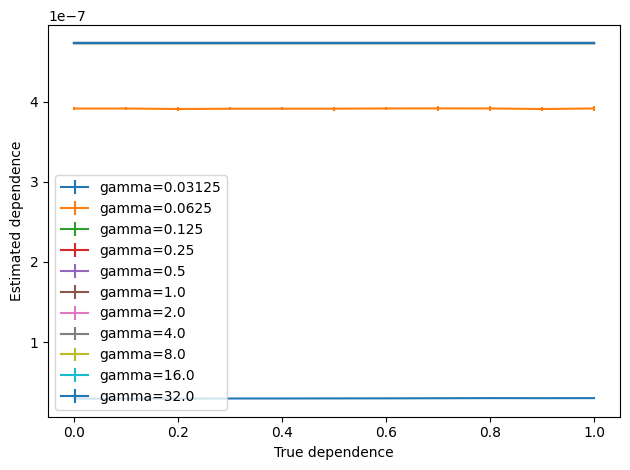

In [237]:
for gamma in means:
    plt.errorbar(deps, means[gamma], yerr=sds[gamma], label=f"gamma={gamma}")
    
plt.xlabel("True dependence")
plt.ylabel("Estimated dependence")
plt.tight_layout()
plt.legend()

In [166]:
from sklearn.preprocessing import KernelCenterer
from sklearn.metrics.pairwise import rbf_kernel

x_size = 64
batch_size = 128
dep = 0.5

X = sd * torch.randn(batch_size, x_size) + 3
eps = sd * torch.randn(batch_size, x_size)
Y = dep * X + (1 - dep) * eps

# Kx = rbf_kernel(X, gamma=1)
# Ky = rbf_kernel(Y, gamma=1)

Kx = get_rbf_kernel(X, gamma=1)
Ky = get_rbf_kernel(Y, gamma=1)

print(Kx.mean(), Kx.std())
print(Ky.mean(), Ky.std())

kc = KernelCenterer()
Kx = kc.fit_transform(Kx)
Ky = kc.fit_transform(Ky)

print(Kx.mean(), Kx.std())
print(Ky.mean(), Ky.std())

tensor(0.0078) tensor(0.0880)
tensor(0.0078) tensor(0.0880)
0.0 0.08804240366863003
2.829090043829363e-18 0.08804240366863003


In [224]:
sds = [1, 10, 100, 1000]
drifts = [1, 10, 100, 1000]
for sd in sds:
    for drift in drifts:
        # X = sd * torch.randn(batch_size, x_size) + drift
        X = torch.randn(1028, 1028)
        # Kx = rbf_kernel(X, gamma=1)
        Kx = get_rbf_kernel(X, gamma=2)
        print(drift, sd, X.mean(), X.std(), Kx.mean().item(), Kx.std().item())

1 1 tensor(-1.6991e-05) tensor(1.0008) 0.0009727626456879079 0.031173983588814735
10 1 tensor(0.0001) tensor(1.0009) 0.0009727626456879079 0.031173983588814735
100 1 tensor(-0.0002) tensor(0.9994) 0.0009727626456879079 0.031173983588814735
1000 1 tensor(-0.0012) tensor(0.9991) 0.0009727626456879079 0.031173983588814735
1 10 tensor(0.0007) tensor(0.9997) 0.0009727626456879079 0.031173983588814735
10 10 tensor(-0.0008) tensor(1.0003) 0.0009727626456879079 0.031173983588814735
100 10 tensor(0.0008) tensor(1.0009) 0.0009727626456879079 0.031173983588814735
1000 10 tensor(0.0012) tensor(0.9997) 0.0009727626456879079 0.031173983588814735
1 100 tensor(0.0006) tensor(0.9999) 0.0009727626456879079 0.031173983588814735
10 100 tensor(-0.0007) tensor(0.9998) 0.0009727626456879079 0.031173983588814735
100 100 tensor(0.0003) tensor(0.9995) 0.0009727626456879079 0.031173983588814735
1000 100 tensor(-0.0013) tensor(1.0011) 0.0009727626456879079 0.031173983588814735
1 1000 tensor(0.0015) tensor(0.9988)

In [179]:
def get_rbf_kernel(x, gamma=1):
	# pairwise_dists = torch.cdist(x, x, p=2) ** 2
    pairwise_dists = torch.from_numpy(euclidean_distances(x, x)) ** 2
    return (-gamma * pairwise_dists).exp()


X = torch.randn(32, 32) + 3
print(X.mean())

Kx1 = get_rbf_kernel(X, gamma=1)
Kx2 = get_rbf_kernel(X, gamma=2)

print(Kx1.mean(), Kx2.mean())

tensor(3.0106)
tensor(0.0312) tensor(0.0312)


In [221]:
X1 = torch.randn(1024, 4)
X2 = torch.randn(1024, 4)

print(X1.mean(), X2.mean())
get_rbf_kernel(X1).mean().item(), get_rbf_kernel(X2).mean().item()

tensor(-0.0165) tensor(0.0002)


(0.041562519967556, 0.04302987456321716)

In [201]:
np.exp((-euclidean_distances(X1) ** 2)).mean()

0.031250227